# Starbucks Capstone Challenge

### Introduction

We address the issue that not all users receive the same offer by looking at a general offer impact factor and assessing offer characteristics across the population.


Which demographic groups respond best to which offer type. We will address this using latent factors.

Found informational offers hard to assess

Offer counts only use the event_offer completed tag, since the transactions are not necessarily just offer-related.  The overall amount is used to provide reference and also adress the issue that "some demographic groups will make purchases even if they don't receive an offer"

### Example

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.


### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

In [344]:
import pandas as pd
import numpy as np
import math
import json
import math
import matplotlib.pyplot as plt
import seaborn as sns

import plotly.graph_objs as go

exec(open("./randomforestfunctions.py").read())

import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline

# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [2]:

#thanks Udacity course
def create_dummy_df(df, cat_cols, dum_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - list of strings that are associated with names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            5. Use a prefix of the column name with an underscore (_) for separating 
            
    '''
    new_df = df.copy()
    for col in  cat_cols:
        try:
            dums =  pd.get_dummies(df[col], prefix=col, prefix_sep='_', drop_first=False, dummy_na=dum_na)
            new_df = pd.concat([new_df.drop(col, axis=1), dums], axis=1)
        except:
            print(col)
            continue
    return new_df

def list_to_cols(series):
    '''
    INPUT:
    series consisting of a list 
    
    OUTPUT:
    dataframe where items in the list are columns
    '''
    column_names = []
    for i in series:
        if isinstance(i, float) == False:
            for n in i:
                if n not in column_names:
                    column_names.append(n)
    df = pd.DataFrame(columns = column_names)
    series = series.fillna('mk162rl8619')
    for z in column_names:
        df[z] = [1 if z in x else 0 for x in series]
    return(df)

def get_years(date_int):
    '''
    INPUT:
    date in the format YYYYMMDD
    
    OUTPUT:
    2020 - year in question
    
    Decided month to month variation was probably not super important
    '''
    string = str(date_int)
    short = string[0:4]
    year = int(short)
    year = 2020 - year
    return(year)


def new_offer_id(col1, col2):
    new_col = []
    for i in range(len(col1)):
        if isinstance(col1[i], str):
            new_col.append(col1[i])
            if isinstance(col2[i], str):
                print('doubleval')
        elif isinstance(col2[i], str):
            new_col.append(col2[i])
            if isinstance(col1[i], str):
                print('doubleval')
        else:
            new_col.append(col1[i])
    if len(new_col) == len(col1):
        return(new_col)
    else:
        print('fail')
        

def mapper(col):
    coded_dict = dict()
    cter = 1
    encoded = []
    
    for val in df[col]:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        encoded.append(coded_dict[val])
    return encoded


In [319]:
def lm(df_x, df_y, df):
    '''
    INPUT:
    string of independent var, string of dependent var, string of group, df hosting, string of nested group if relevant
    
    OUTPUT:
    a statsmodel instance of a mixed effects/multilevel model
    
    '''
    
    try:
        X = sm.add_constant(df_x)
        try:
            est = sm.OLS(df_y, X).fit()
            return(est)
        except:
            print(str(df_x) + 'fit failed')
    except:
        print(str(df_x) + 'did not converge')
    return('FAIL')

def logm(df_x, df_y, df):
    '''
    INPUT:
    string of independent var, string of dependent var, string of group, df hosting, string of nested group if relevant
    
    OUTPUT:
    a statsmodel instance of a mixed effects/multilevel model
    
    '''
    
    try:
        est = sm.Logit(df_y, df_x).fit() 
        return(est)
    except:
        print(str(df_x) + 'did not converge')
    return('FAIL')

def plot_sig_results(sig_df):
    fig = go.Figure()

    fig.add_trace(go.Bar(x=sig_df['features'], y = sig_df['coef'], name = 'Ratings_Score_Top_Coef', 
                     marker=dict(color =   sig_df['coef'],
                                 colorscale='bluered',   # choose a colorscale
                                 opacity=0.8,
                                 showscale = True
                                ), 
                     error_y=dict(type='data',
                                array= list(sig_df['conf_int_975'] - sig_df['conf_int_025']),
                                visible=True)
                                ))
    return(fig)

In [46]:
def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
  
    
    df['interact'] = [1 if i > 0 else  0 for i in df['event_offer completed']]
    user_item_df = df[['offer_id', 'user_id', 'interact']]
    user_item_gb = user_item_df.groupby(['user_id','offer_id'])['interact'].max().unstack(fill_value = float('nan'))
    user_item = pd.DataFrame(user_item_gb)

    return user_item # return the user_item matrix 




def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = create_user_item_matrix(df_train)
    user_item_test = create_user_item_matrix(df_test)
    test_idx = user_item_test.index
    test_arts = user_item_test.columns
    
    return user_item_train, user_item_test, test_idx, test_arts


def FunkSVD(ratings, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    ratings_np = np.array(ratings)
    n_users = ratings.shape[0]
    n_items = ratings.shape[1]
    num_ratings = (n_users)*(n_items)
    
    # initialize the user and movie matrices with random values
    user_mat = np.random.rand(n_users,latent_features)
    items_mat = np.random.rand(latent_features, n_items) 
    
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    sse_totals = []
    for i in range(0, iters):
        old_sse = sse_accum
        sse_accum = 0
        for n in range(n_users): 
            for m in range(n_items):
                # if the rating exists
                
                if math.isnan(ratings_np[n,m]) == False: 
                    
                    error =  ratings_np[n, m] - np.dot(user_mat[n, :], items_mat[:, m])
                    sse_accum += error**2
                    # update the values in each matrix in the direction of the gradient
                    for x in range(latent_features):
                        
                        user_mat[n, x] += (learning_rate*(2*error*items_mat[x,m]))
                        items_mat[x, m] += (learning_rate*(2*error* user_mat[n, x]))
                        
        
        # print results for iteration
        sse_totals.append(sse_accum/m)
        print(i + 1, sse_accum/m)
    user_mat = pd.DataFrame(user_mat)
    user_mat.index = ratings.index
    items_mat = pd.DataFrame(items_mat)
    items_mat.columns = ratings.columns
    print(iters, sse_accum/m)
    return user_mat, items_mat, sse_totals

# Use these cells to see how well you can use the training 
# decomposition to predict on test data

def latent_feature_pred(ui_train, ui_test, iters_, lf, lr):
    '''
    INPUT: train mat, test mat, list of latent factor sizes
    
    OUTPUT: acc test, all
    
    STEPS:
        1. Creates SVD decomposition (Tries twice)
        2. subsets by number of latent factors
        3. finds dot product
        4. subsets test predictions
        5. gets test and pred accuracy
    
    '''
    
    u, vt, sse = FunkSVD(ui_train, latent_features=lf, learning_rate=lr, iters=iters_)

    print('funksvd')
    test_ind = ui_test.index
    row_ind = ui_train.index.isin(test_ind)  
    
    test_cols = ui_test.columns
    col_ind = ui_train.columns.isin(test_cols)
    
    train_ind = ui_train.index
    row_ind_train = ui_test.index.isin(train_ind)
    ui_test_short = (ui_test.loc[row_ind_train])
    
    u_test = u.loc[row_ind]
    vt_test = vt.loc[:, vt.columns.isin(test_cols)]

    test_sse_accum = 0
    
    for n in ui_test_short.index: 
       # print(n)
        for m in ui_test_short.columns:
                # if the rating exists
          #  print(m)
            if math.isnan(ui_test_short.loc[n,m]) == False: 
                
                error =  ui_test_short.loc[n, m] - np.dot(u_test.loc[n, :], vt_test.loc[:, m])
                test_sse_accum += error**2
                    # update the values in each matrix in the direction of the gradient
  
    
      
    
    return test_sse_accum/m, sse[len(sse)-1]
        
def test_different_lf(lf, lr, iter_ls):
    
    sse_test_ls = []
    sse_all_ls = []
    for i in iter_ls:
        sse_test, sse_all = latent_feature_pred(user_item_train, user_item_test, i, lf, lr)
        sse_test_ls.append(sse_test)
        print(sse_test)
        sse_all_ls.append(sse_all)
        
    return(sse_test_ls, sse_all_ls)
    
def plot_sse_fig(iters_ls, met_all_ls, met_test_ls = [], met_label = "SSE"): 
    '''
    INPUT: list of latent factor vals, list of all/test accuracies, label for graphs
    
    OUTPUT: none, plots figures
    '''
    plt.figure()
    plt.plot(iters_ls, met_all_ls, label='All ' + met_label)
    
    if len(met_test_ls) > 0:
        plt.plot(iters_ls, met_test_ls, label='Test')
        
    plt.xlabel('Number of Iterations')
    plt.ylabel(met_label)
    plt.title(met_label + ' vs. Iterations')
    plt.legend()
    plt.show()

In [277]:
tpr_df = transcript.merge(profile, left_on = 'person', right_on = 'id')
#density of 118 year olds makes it seem likely that this is some kind of missingness in the data that should be disregarded
tpr_clean = tpr_df[~(tpr_df['age'] == 118)].reset_index(drop = True)

In [278]:
value_df = pd.DataFrame(list(tpr_clean['value']))
offer_ids = new_offer_id(value_df['offer id'], value_df['offer_id']) 

value_df = value_df.drop(['offer id', 'offer_id', 'reward'], axis = 1)
value_df['offer_id'] = offer_ids

value_df = value_df.merge(portfolio, left_on = 'offer_id', right_on = 'id', how = 'left')


df = pd.concat([tpr_clean, value_df], axis = 1)
df = df.drop(['value'], axis = 1)

In [279]:
person_encoded = mapper('person')
del df['person']
del df['id']
df['user_id'] = person_encoded

#nas were set to 2
offer_encoded = mapper('offer_id')
del df['offer_id']
df['offer_id'] = offer_encoded

# show header
df.head()

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,2
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,2


In [280]:
df['offer_id'] = df['offer_id'].replace(2, float('nan'))
df.head()

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,NaN
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,NaN


In [281]:
df.sort_values(['user_id', 'time'], axis = 0).reset_index(drop = True)

,event,time,gender,age,became_member_on,income,amount,reward,channels,difficulty,duration,offer_type,user_id,offer_id
0,offer received,0,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
1,offer viewed,6,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
2,transaction,132,F,75,20170509,100000.0,19.89,NaN,NaN,NaN,NaN,NaN,1,NaN
3,offer completed,132,F,75,20170509,100000.0,NaN,5.0,"[web, email, mobile]",5.0,7.0,bogo,1,1.0
4,transaction,144,F,75,20170509,100000.0,17.78,NaN,NaN,NaN,NaN,NaN,1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
272757,offer viewed,504,M,47,20171013,94000.0,NaN,0.0,"[web, email, mobile]",0.0,4.0,informational,14824,7.0
272758,offer received,576,M,47,20171013,94000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14824,11.0
272759,offer viewed,576,M,47,20171013,94000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14824,11.0
272760,offer received,576,F,58,20161020,78000.0,NaN,10.0,"[web, email, mobile, social]",10.0,5.0,bogo,14825,11.0


In [282]:
channels_df = list_to_cols(df['channels'])
df = df.drop(['channels'],axis = 1)

In [283]:
df['years_member'] = df['became_member_on'].apply(get_years)
df = df.drop(['became_member_on'],axis = 1)

In [284]:
df_for_amount['reward']
#most people are two this data is probably older

user_id
1        60.0
2        25.0
3        67.0
4        12.0
5        85.0
         ... 
14821    40.0
14822    30.0
14823    22.0
14824    20.0
14825    20.0
Name: reward, Length: 14825, dtype: float64

In [285]:
for_cats_df = df.select_dtypes(include=['object'])

cats_df = create_dummy_df(df, for_cats_df.columns, False)

In [286]:
new_df = pd.concat([cats_df, channels_df], axis = 1)


df_gb = new_df.groupby(['user_id', 'offer_id']).agg('mean')


df_gb = df_gb.reset_index()
df_gb.head()

df_gb_time = df_gb.sort_values(by = 'time', axis = 0).reset_index(drop = True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017F3FD71E80>,
      dtype=object)

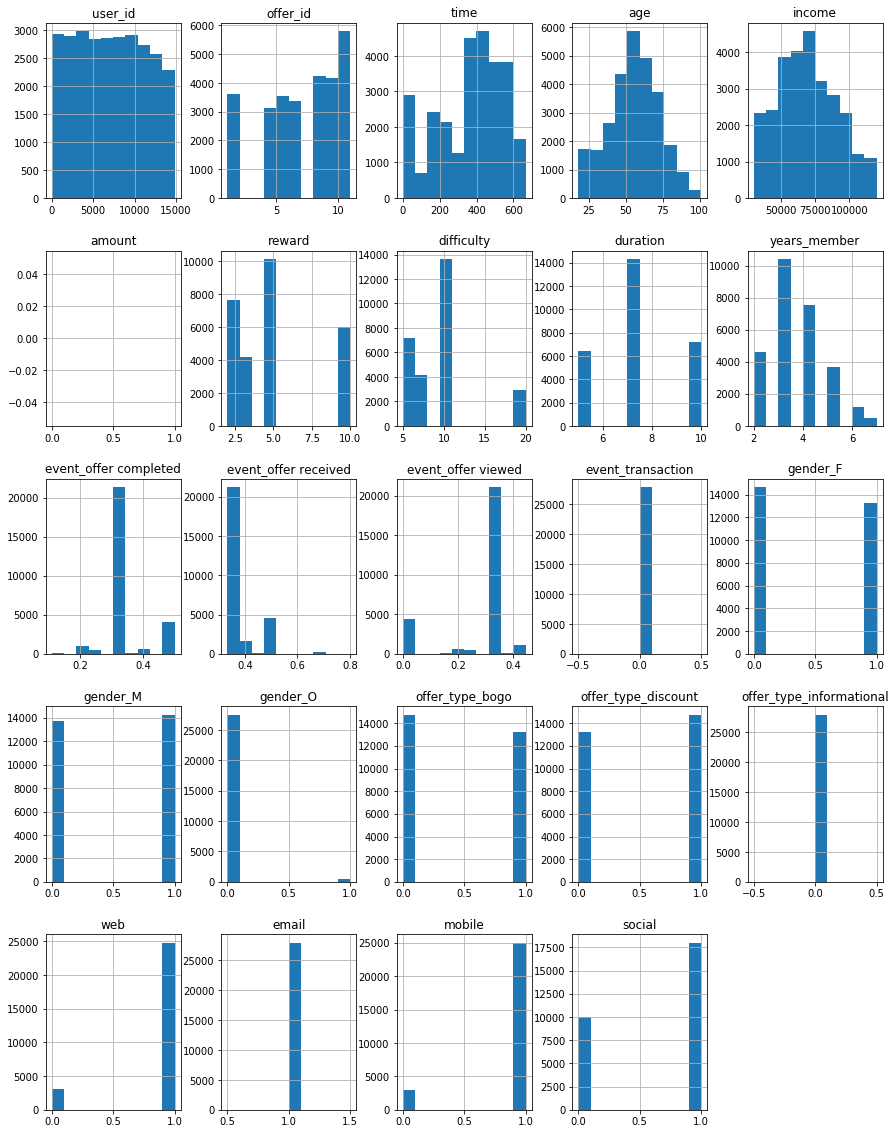

In [287]:
df_gb[df_gb['event_offer completed'] > 0].hist(figsize = (15,20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000017F3D6F0F28>,
      dtype=object)

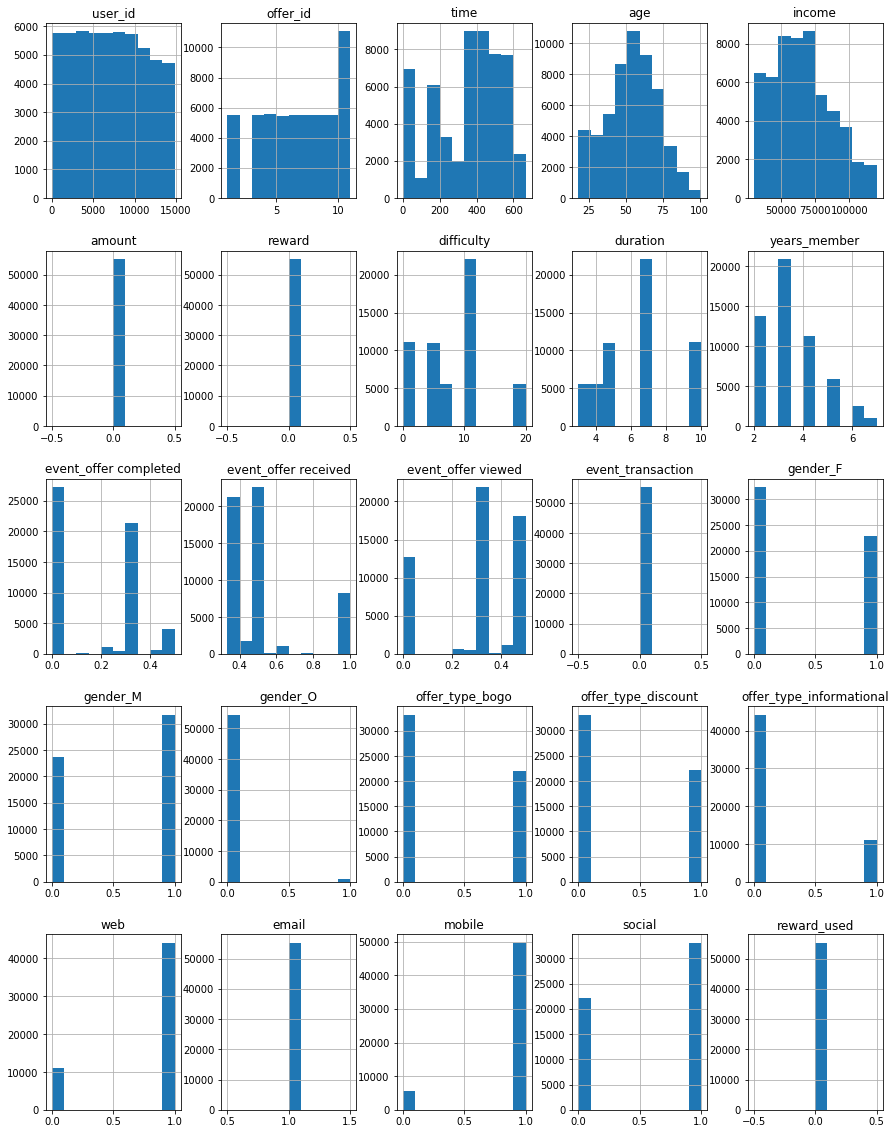

In [153]:
df_gb.hist(figsize = (15,20))

# WHO IN GENERAL WILL BE AFFECTED BY AN OFFER?

In [336]:
df_gb['event_offer viewed']

0        0.333333
1        0.500000
2        0.333333
3        0.333333
4        0.333333
           ...   
55217    0.000000
55218    0.500000
55219    0.500000
55220    0.500000
55221    0.500000
Name: event_offer viewed, Length: 55222, dtype: float64

In [365]:
def offer_influence(df = df_for_amount_new):
    new_offer_impact = []
    for i, j in enumerate(df['event_offer completed']):
        if j > 0:
            if list(df['event_offer viewed'])[i] > 0:
                new_offer_impact.append(1)
            else:
                new_offer_impact.append(0)
        else:
            new_offer_impact.append(0)
    return(new_offer_impact)

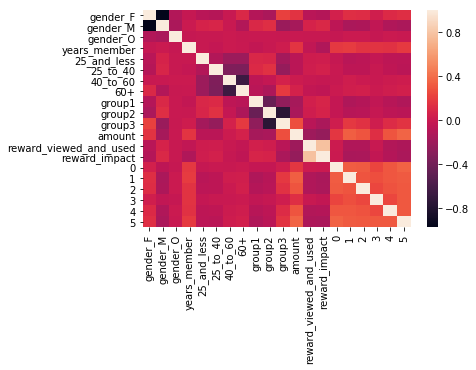

In [340]:
users_df = df_gb[['user_id', 'gender_F', 'gender_M', 'gender_O','years_member']]

age_groups = ['25_and_less' if i < 25 else '25_to_40' if i < 40 else '40_to_60' if i < 60 else '60+' for i in df_gb['age']]
age_groups = pd.Series(age_groups, name = 'age_cats')

age_groups_df = pd.get_dummies(age_groups).reset_index(drop = True)

income_groups = ['None' if i < 1 else 'group1' if i < 40000 else 'group2' if i < 75000 else 'group3' for i in df_gb['income']]
income_groups = pd.Series(income_groups, name = 'income_cats')

income_groups_df = pd.get_dummies(income_groups).reset_index(drop = True)
cats_df2 = pd.concat([age_groups_df, income_groups_df], axis = 1)


users_df = users_df.reset_index(drop = True)
users_df2 = pd.concat([users_df, cats_df2], axis = 1)

users_df2 = users_df2.groupby('user_id').agg('mean')

df_for_amount = new_df.groupby(['user_id']).agg('sum')
df_for_amount_new = df_for_amount[df_for_amount.index.isin(users_df2.index)]

users_df2['amount'] = [i if math.isnan(i) == False else 0 for i in df_for_amount_new['amount']]
users_df2['reward_viewed_and_used'] = offer_influence()
users_df2['reward_impact'] = users_df2['reward_viewed_and_used']/users_df2['amount']
users_df2['reward_impact'] = [i if math.isnan(i) == False else 0 for i in users_df2['reward_impact']]

users_df_corr = pd.concat([users_df2, u], axis =1)
sns.heatmap(users_df_corr.corr(), annot=False, fmt=".2f");

In [348]:
X = users_df2.reset_index(drop = True)
X = X.drop(['reward_impact', 'reward_viewed_and_used', 'amount'], axis = 1)
y = np.array(users_df2['reward_impact'])


best_param = specify_best(model = RandomForestRegressor(random_state = 15), typ = 'RF', X = X, y = y)

rf = RandomForestRegressor(min_samples_split=best_param.get('min_samples_split'), 
                           max_features= best_param.get('max_features'),random_state = 15)

rf_res = run_models_kfold(rf, X, users_df2['reward_impact'])

#because of the small # of features, only 2 were > mean so in order to cast a wider net, we've included top 5
eprf = top_features(rf_res[2], featn = 11, mean = False)
print_vals(best_param, rf_res, eprf)

mss: 82
max_feat: 2
mean_mae: 0.008507381319278978
mean_mse: 0.00021326942893466102

frequency: 

10
10
10
10
10
10
10
10
10
10
10

feat_imp: 

-0.0014553674872500174
-0.0007513787187228279
-0.0006711456563670825
-0.00019707453455407157
0.000319252564137908
0.001734052433590983
0.0019456632059017542
0.002059598278262444
0.002284070366703927
0.011095789872643128
0.04421281461881508

top_ features

60+
40_to_60
25_to_40
gender_O
25_and_less
gender_M
group1
group2
gender_F
group3
years_member


In [349]:
models = []
cols = X.columns

for i in cols:
    lm_i = lm(users_df2[i], users_df2['reward_impact'], users_df2)
    models.append(lm_i)
    if lm_i != 'FAIL':
        print(lm_i.summary())

                            OLS Regression Results                            
Dep. Variable:          reward_impact   R-squared:                         nan
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Sun, 18 Oct 2020   Prob (F-statistic):                nan
Time:                        14:31:28   Log-Likelihood:                    nan
No. Observations:               14820   AIC:                               nan
Df Residuals:                   14820   BIC:                               nan
Df Model:                          -1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const             nan        nan        nan        n

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning:

invalid value encountered in greater

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in greater

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:903: RuntimeWarning:

invalid value encountered in less

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:1912: RuntimeWarning:

invalid value encountered in less_equal

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\scipy\stats\stats.py:1548: RuntimeWarning:

invalid value encountered in sign



In [350]:
lm_results = pd.DataFrame({
    
    'features': [i.pvalues.index[1] for i in models],
    'pvalues':[i.pvalues[1] for i in models],
    'coef': [i.params[1] for i in models],
    'conf_int_025': [i.conf_int()[0][1] for i in models],
    'conf_int_975': [i.conf_int()[1][1] for i in models]
    
})

lm_results[['features', 'pvalues']].style.background_gradient()

C:\Users\madke\Anaconda3\lib\site-packages\matplotlib\colors.py:489: RuntimeWarning:

invalid value encountered in less



,features,pvalues
0,gender_F,nan
1,gender_M,0.000000
2,gender_O,0.392870
3,years_member,0.000000
4,25_and_less,0.000031
5,25_to_40,0.000000
6,40_to_60,0.059223
7,60+,0.000001
8,group1,0.000000
9,group2,0.000000


In [351]:

lm_results_sig = lm_results[lm_results['pvalues'] < 0.05]
plot_sig_results(lm_results_sig)

Takeaways:
* consistency between rf regression and lm regression
* biggest predictors of rewards increasing purchases: Male, 40 and less, make less than 75k a year
* biggest predictors of rewards not greatly increasing purchases: Female, 60 +, longer years member, making greater than 75k

While there may be greater long term benefits to rewarding long term members, and interaction effects are possible, it seems most impactful to reward people who are male, low-mid income, and/or young.

# WHICH OFFERS IN GENERAL ARE MOST IMPACTFUL?

In [376]:
df_gb.columns

Index(['user_id', 'offer_id', 'time', 'age', 'income', 'amount', 'reward',
       'difficulty', 'duration', 'years_member', 'event_offer completed',
       'event_offer received', 'event_offer viewed', 'event_transaction',
       'gender_F', 'gender_M', 'gender_O', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'web', 'email',
       'mobile', 'social'],
      dtype='object')

In [ ]:
offer_df = df_gb[['user_id','offer_id', 'event_offer completed', 'event_offer viewed', 'event_offer received',  'offer_type_bogo','offer_type_discount', 'offer_type_informational', 'web', 'email', 'mobile', 'social', 'reward']]
offer_df['reward_viewed_and_used'] = offer_influence(offer_df)

In [368]:
X = offer_df.reset_index(drop = True)
X = X.drop(['event_offer completed',  'event_offer viewed', 'event_offer received',  'reward_viewed_and_used','', 'offer_id'], axis = 1)
y = np.array(offer_df['reward_viewed_and_used'])


best_param = specify_best(model = RandomForestRegressor(random_state = 15), typ = 'RF', X = X, y = y)

rf = RandomForestRegressor(min_samples_split=best_param.get('min_samples_split'), 
                           max_features= best_param.get('max_features'),random_state = 15)

{'max_features': 4, 'min_samples_split': 82}


In [369]:
rf_res = run_models_kfold(rf, X, offer_df['reward_viewed_and_used'])

In [370]:
#because of the small # of features, only 2 were > mean so in order to cast a wider net, we've included top 5
eprf = top_features(rf_res[2], featn = 8, mean = False)
print_vals(best_param, rf_res, eprf)

mss: 82
max_feat: 4
mean_mae: 0.3580993670576159
mean_mse: 0.18721095211027367

frequency: 

10
10
10
10
10
10
10
10

feat_imp: 

-0.0053866133612489025
-0.0036826135903737997
0.0
0.001781630311206028
0.005059739315259287
0.05986518907326386
0.08624426531638976
0.10601407975616255

top_ features

offer_type_discount
web
email
user_id
mobile
reward
social
offer_type_informational


In [371]:
models = []
cols = X.columns

for i in cols:
    lm_i = logm(offer_df[i], offer_df['reward_viewed_and_used'], offer_df)
    models.append(lm_i)
    if lm_i != 'FAIL':
        print(lm_i.summary())

Optimization terminated successfully.
         Current function value: 0.684838
         Iterations 3
                             Logit Regression Results                             
Dep. Variable:     reward_viewed_and_used   No. Observations:                55222
Model:                              Logit   Df Residuals:                    55221
Method:                               MLE   Df Model:                            0
Date:                    Sun, 18 Oct 2020   Pseudo R-squ.:               -0.004138
Time:                            15:00:11   Log-Likelihood:                -37818.
converged:                           True   LL-Null:                       -37662.
Covariance Type:                nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
user_id    -3.133e-05   1.04e-06    -30.060      0.000   -3.34e-05   -2.93e-

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning:

invalid value encountered in greater

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning:

invalid value encountered in greater



                             Logit Regression Results                             
Dep. Variable:     reward_viewed_and_used   No. Observations:                55222
Model:                              Logit   Df Residuals:                    55221
Method:                               MLE   Df Model:                            0
Date:                    Sun, 18 Oct 2020   Pseudo R-squ.:                -0.01580
Time:                            15:00:11   Log-Likelihood:                -38257.
converged:                           True   LL-Null:                       -37662.
Covariance Type:                nonrobust   LLR p-value:                       nan
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
offer_type_bogo     0.0844      0.013      6.259      0.000       0.058       0.111
Optimization terminated successfully.
         Current function value: 0.691688
    

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning:

invalid value encountered in greater

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\statsmodels\base\model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



         Current function value: 0.554560
         Iterations: 35
                             Logit Regression Results                             
Dep. Variable:     reward_viewed_and_used   No. Observations:                55222
Model:                              Logit   Df Residuals:                    55221
Method:                               MLE   Df Model:                            0
Date:                    Sun, 18 Oct 2020   Pseudo R-squ.:                  0.1869
Time:                            15:00:11   Log-Likelihood:                -30624.
converged:                          False   LL-Null:                       -37662.
Covariance Type:                nonrobust   LLR p-value:                       nan
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
offer_type_informational   -20.4556    263.249     -0.078      0.938    -536.415    

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning:

invalid value encountered in greater

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\statsmodels\tools\tools.py:689: RuntimeWarning:

invalid value encountered in greater



                             Logit Regression Results                             
Dep. Variable:     reward_viewed_and_used   No. Observations:                55222
Model:                              Logit   Df Residuals:                    55221
Method:                               MLE   Df Model:                            0
Date:                    Sun, 18 Oct 2020   Pseudo R-squ.:                -0.01401
Time:                            15:00:11   Log-Likelihood:                -38190.
converged:                           True   LL-Null:                       -37662.
Covariance Type:                nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
web           -0.1256      0.010    -13.171      0.000      -0.144      -0.107
Optimization terminated successfully.
         Current function value: 0.682016
         Iterations

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning:

invalid value encountered in greater

C:\Users\madke\AppData\Roaming\Python\Python36\site-packages\numpy\linalg\linalg.py:1872: RuntimeWarning:

invalid value encountered in greater



                             Logit Regression Results                             
Dep. Variable:     reward_viewed_and_used   No. Observations:                55222
Model:                              Logit   Df Residuals:                    55221
Method:                               MLE   Df Model:                            0
Date:                    Sun, 18 Oct 2020   Pseudo R-squ.:                -0.01620
Time:                            15:00:12   Log-Likelihood:                -38273.
converged:                           True   LL-Null:                       -37662.
Covariance Type:                nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
reward         0.0047      0.002      2.985      0.003       0.002       0.008


In [372]:
logm_results = pd.DataFrame({
    
    'features': [i.pvalues.index[0] for i in models],
    'pvalues':[i.pvalues[0] for i in models],
    'coef': [i.params[0] for i in models],
    'conf_int_025': [i.conf_int()[0][0] for i in models],
    'conf_int_975': [i.conf_int()[1][0] for i in models]
    
})

logm_results[['features', 'pvalues']].style.background_gradient()

,features,pvalues
0,user_id,0.000000
1,offer_type_bogo,0.000000
2,offer_type_discount,0.000000
3,offer_type_informational,0.938063
4,web,0.000000
5,email,0.000000
6,mobile,0.000000
7,social,0.000000
8,reward,0.002838


In [373]:

logm_results_sig = logm_results[logm_results['pvalues'] < 0.05]

plot_sig_results(logm_results_sig)

In [332]:
offer_df.columns

Index(['offer_id', 'event_offer completed', 'offer_type_bogo',
       'offer_type_discount', 'offer_type_informational', 'web', 'email',
       'mobile', 'social', 'reward', 'reward_used'],
      dtype='object')

In [374]:
offer_agg = offer_df.groupby('offer_id').sum().reset_index()

fig = go.Figure()
fig.add_trace(go.Bar(x=offer_agg['offer_id'], y = offer_agg['reward_viewed_and_used']/[1 if i > 0 else 0 for i in offer_agg['event_offer recieved']], name = 'times_reward_used'))

KeyError: 'event_offer received'

# FUNKSVD

In [17]:
df_train = df_gb_time.head(int(np.rint(df_gb_time.shape[0]*.7)))
df_test = df_gb_time.tail(int(np.rint(df_gb_time.shape[0]*.3)))
user_item_train, user_item_test, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

C:\Users\madke\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [ ]:
sse_tests = []
sse_alls = []
latent_factors = []

learning_rate = 0.000001
for i in range(8, 10, 3):
    sse_test_ls, sse_all_ls = test_different_lf(i, learning_rate, iter_ls = range(5000, 5400, 200))
    sse_tests.append(sse_test_ls)
    sse_alls.append(sse_all_ls)
    latent_factors.append(i)
    
    

In [55]:


user_item = create_user_item_matrix(df_gb)

#learning_rate = 0.01
u, vt, sse_totals = FunkSVD(user_item, latent_features=6, learning_rate=0.02, iters=1000)

Optimization Statistics
Iterations | Mean Squared Error 
1 1265.5277972365177
2 1195.6534552075966
3 1144.7552443726545
4 1095.8511136137818
5 1048.852919957678
6 1003.6559478997798
7 960.1537547397578
8 918.2531146432336
9 877.887080527829
10 839.0240709944834
11 801.671218617963
12 765.8711113225721
13 731.6923839494586
14 699.2159231067362
15 668.5192610861459
16 639.6618723652008
17 612.6736390885364
18 587.5478990488328
19 564.2394591079259
20 542.6670311610694
21 522.7189529663498
22 504.2608507030002
23 487.14399534391134
24 471.213364881283
25 456.31473782183485
26 442.30044147810037
27 429.03362616635354
28 416.3911192443539
29 404.2650298940955
30 392.56333444901446
31 381.209686128621
32 370.1426771798237
33 359.31474848220455
34 348.6909002686806
35 338.24731250876033
36 327.9699382141056
37 317.8530925037284
38 307.89803174129645
39 298.1115067667352
40 288.5042840525145
41 279.0896541795468
42 269.8819792788714
43 260.8953592325393
44 252.14251047774144
45 243.63394395779

371 2.7264488569643013
372 2.7053145676856283
373 2.6843071235611067
374 2.663424709270546
375 2.6426655616259387
376 2.6220279726799416
377 2.6015102926395466
378 2.581110932571346
379 2.5608283668865712
380 2.5406611355960926
381 2.5206078463250927
382 2.500667176082456
383 2.4808378727766485
384 2.461118756475768
385 2.4415087204084944
386 2.4220067317054665
387 2.4026118318818575
388 2.383323137063036
389 2.364139837958207
390 2.3450611995855843
391 2.326086560758247
392 2.3072153333360124
393 2.288447001254333
394 2.2697811193391377
395 2.251217311919399
396 2.2327552712488687
397 2.214394755749308
398 2.1961355880886027
399 2.1779776531067374
400 2.159920895603679
401 2.1419653180018923
402 2.1241109778987393
403 2.1063579855205945
404 2.0887065010935313
405 2.0711567321425552
406 2.053708930732454
407 2.0363633906622827
408 2.019120444625059
409 2.001980461343388
410 1.984943842691879
411 1.9680110208150137
412 1.9511824552509833
413 1.9344586300679305
414 1.917840051021744
415 

727 0.28566162515821036
728 0.2847174561232594
729 0.2837785536441793
730 0.28284485877552046
731 0.28191631351401986
732 0.28099286079059627
733 0.28007444446219193
734 0.2791610093033208
735 0.27825250099753934
736 0.2773488661286573
737 0.27645005217182955
738 0.27555600748443987
739 0.2746666812968731
740 0.27378202370309307
741 0.2729019856511903
742 0.2720265189336639
743 0.2711555761776772
744 0.27028911083521817
745 0.26942707717310205
746 0.2685694302629061
747 0.26771612597085515
748 0.2668671209476042
749 0.2660223726179616
750 0.2651818391705523
751 0.26434547954746823
752 0.2635132534338482
753 0.26268512124740895
754 0.26186104412801803
755 0.26104098392720654
756 0.2602249031976592
757 0.25941276518275935
758 0.2586045338060807
759 0.2578001736609477
760 0.25699964999998076
761 0.25620292872467154
762 0.25540997637502927
763 0.2546207601191694
764 0.253835247743109
765 0.2530534076404414
766 0.25227520880218035
767 0.2515006208066114
768 0.25072961380924624
769 0.2499621

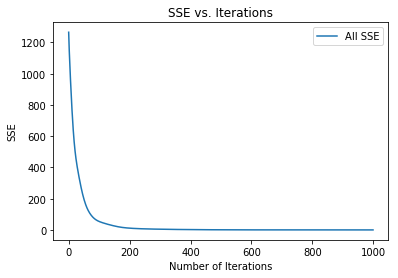

In [56]:
plot_sse_fig(range(1000), sse_totals, met_label = "SSE")

In [59]:

v = vt.T

for_cor = pd.concat([v, u], axis = 0)

,0,1,2,3,4,5
user_id,,,,,,
1,0.733519,0.830973,0.688329,0.233692,0.376631,0.663054
2,1.189134,0.500120,0.532125,0.456993,1.245891,0.205037
3,0.476288,0.784937,0.587246,0.332231,0.603149,0.664323
4,0.281185,1.015579,0.846028,-0.211597,1.315794,0.251268
5,0.346533,0.699192,0.837164,0.555242,0.504703,-0.225238
...,...,...,...,...,...,...
14821,0.713814,0.434745,0.158671,0.127398,0.623298,0.597784
14822,0.225973,-0.042456,0.192779,0.332013,0.006051,0.151658
14823,0.052583,0.112124,-0.115893,0.197491,0.044051,-0.061687


In [63]:
for_cor.to_csv('./output_funksvd.csv')

In [143]:
df_gb.columns

2



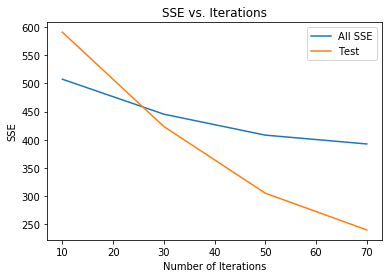

4



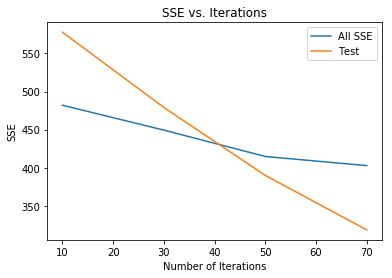

6



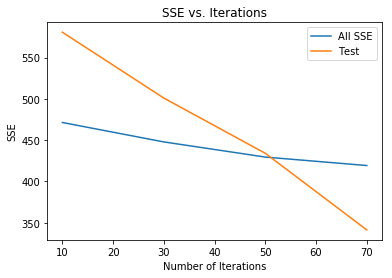

8



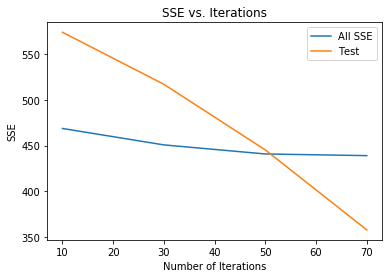

In [372]:
#learning rate .005
for i, j in enumerate(sse_tests):
    print(latent_factors[i])
    print()
    plot_sse_fig(range(10, 80, 20),j, sse_alls[i])


2



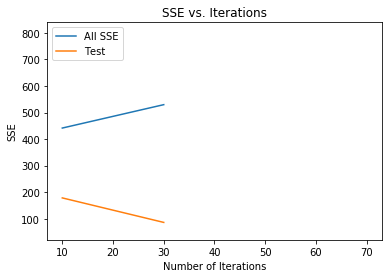

4



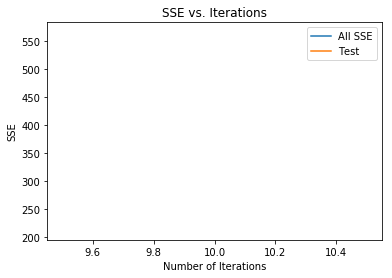

6



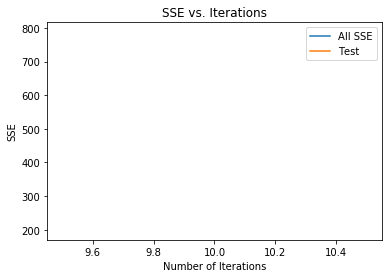

8



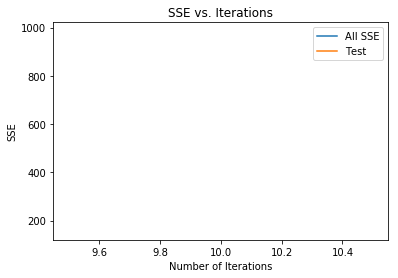

In [378]:
#learning rate 0.05

for i, j in enumerate(sse_tests):
    print(latent_factors[i])
    print()
    plot_sse_fig(range(10, 80, 20),j, sse_alls[i])

2



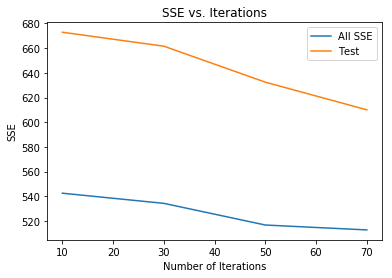

4



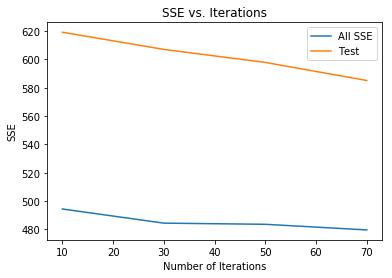

6



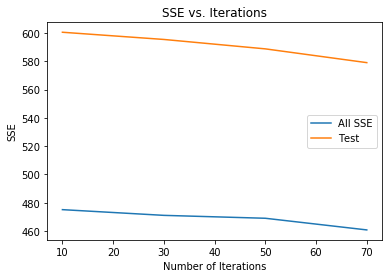

8



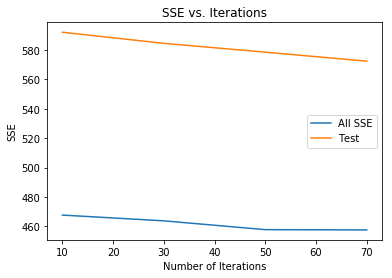

In [381]:
#learning rate .0005
for i, j in enumerate(sse_tests):
    print(latent_factors[i])
    print()
    plot_sse_fig(range(10, 80, 20),j, sse_alls[i])

2



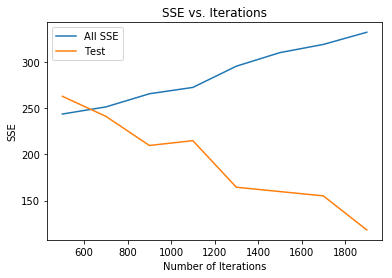

In [25]:
#try more iterations with the low learning rate
#.001, looks like 500 maxed out
for i, j in enumerate(sse_tests):
    print(latent_factors[i])
    print()
    plot_sse_fig(range(500, 2000, 200), j, sse_alls[i])

2



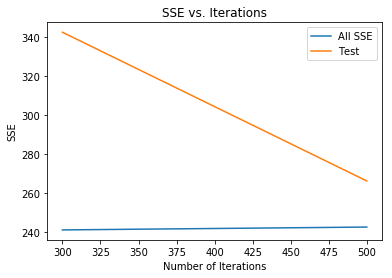

4



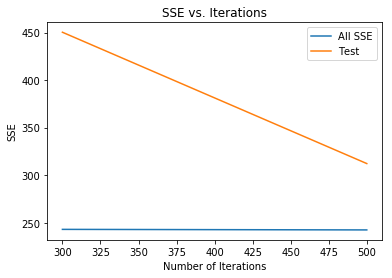

6



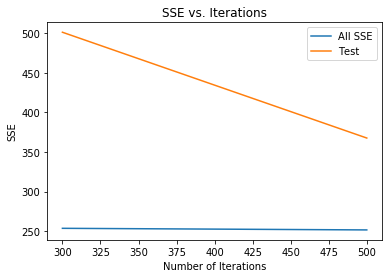

8



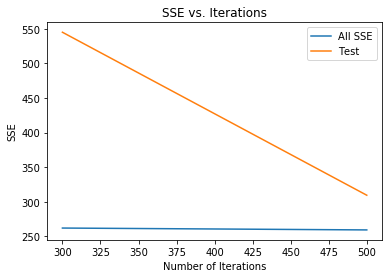

In [27]:
# lr = 0.0005
for i, j in enumerate(sse_tests):
    print(latent_factors[i])
    print()
    plot_sse_fig(range(300, 600, 200), j, sse_alls[i])

2



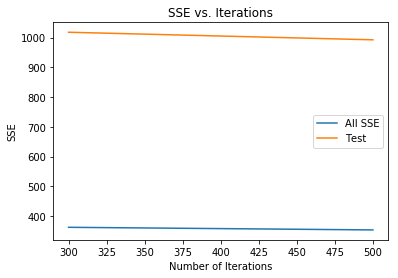

5



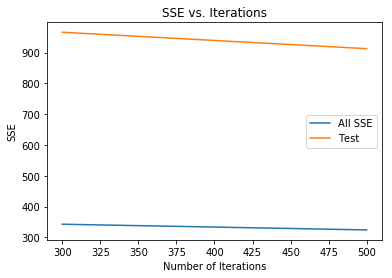

In [31]:
#lr = 0.000001

for i, j in enumerate(sse_tests):
    print(latent_factors[i])
    print()
    plot_sse_fig(range(300, 600, 200), j, sse_alls[i])

It looks like, based on the computational power I have, we will have to either be okay with stopping the algorithm early or overfitting.  We will purse both in further analyses

4



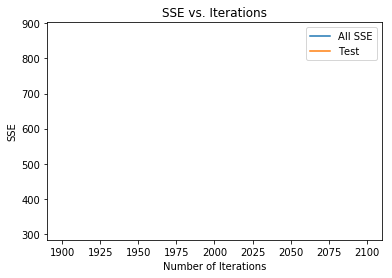

7



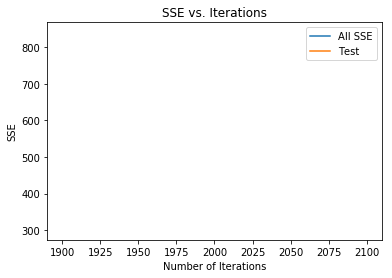